In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gudhi as gd
from gudhi.representations import PersistenceImage, BettiCurve, Entropy

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score

from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde

from pathlib import Path
from tqdm.notebook import tqdm

from itertools import product
from datetime import datetime

# load the methods from the src folder
from src.auxfunctions import get_all_classifications
from src.inputreader import read_persistence_files

In [ ]:
data_input = Path('data_segmented')
input_airyscan = data_input / 'Airyscan'
input_sted = data_input / 'STED'

data_pers = Path('data_processed')
pers_sted = data_pers / 'persistence_sted'
pers_airyscan = data_pers / 'persistence_airyscan'
vectorization_sted = data_pers / 'vectorizations_sted'
vectorization_airyscan = data_pers / 'vectorizations_airyscan'

classification_path = data_pers / 'classification'
classification_path_thresholds = classification_path / 'thresholds'

# Computations: Different thresholds on the persistence diagrams

This can take a long time, the `runs`, `runs_start` and the nameappend or used when doing different runs (on different machines) without the need of any parallizations inside of the program and saving auxiliary steps.

In [ ]:


# STED
preprocessing = 'clip_minmax_gaussian2c_minmax'
df_labels = pd.read_csv(data_pers / 'labels_persistence_sted.csv')
labels = df_labels['labels'].values

birth_thresholds = [0.0, -0.05, -0.1, -0.15, -0.2, -0.25, -0.3]
persistence_thresholds = [0.05, 0.0, 0.1, 0.15, 0.2]

print("TIME:", datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
for pers_thresh, birth_thresh in tqdm(product(persistence_thresholds, birth_thresholds)):
    if birth_thresh == 0.0 and pers_thresh == 0.0:
        continue
    get_all_classifications(preprocessing,
        pers_sted, 
        classification_path_thresholds,
        labels,
        runs=10, 
        run_start=0,
        train_percent='70',
        persistence_threshold=pers_thresh,
        birth_threshold=birth_thresh,
        nameappend=f'thresh-birth-{int(np.abs(birth_thresh)*100):03d}'\
            f'-pers-{int(pers_thresh*100):03d}',
        saveasfile=True,  n_jobs=4)
    print("CURRENT TIME:", datetime.now().strftime('%Y-%m-%d %H:%M:%S'))


In [ ]:
# Airyscan
preprocessing = 'clip_minmax_gaussian2c_minmax'
df_labels = pd.read_csv(data_pers / 'labels_persistence_sted.csv')
labels = df_labels['labels'].values

birth_thresholds = [0.0, -0.05, -0.1, -0.15, -0.2, -0.25, -0.3]
persistence_thresholds = [0.05, 0.0, 0.1, 0.15, 0.2]

print("TIME:", datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
for pers_thresh, birth_thresh in tqdm(product(persistence_thresholds, birth_thresholds)):
    if birth_thresh == 0.0 and pers_thresh == 0.0:
        continue
    get_all_classifications(preprocessing,
        pers_sted, 
        classification_path, labels,
        runs=10, 
        run_start=0,
        train_percent='70',
        persistence_threshold=pers_thresh,
        birth_threshold=birth_thresh,
        nameappend=f'thresh-birth-{int(np.abs(birth_thresh)*100):03d}'\
            f'-pers-{int(pers_thresh*100):03d}',
        saveasfile=True,  n_jobs=4)
    print("CURRENT TIME:", datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

## plots for different thresholds (reading)

In [27]:
df_airy = []
df_sted = []

preprocessing = 'clip_minmax_gaussian2c_minmax'

for file in Path(classification_path / 'thresholds').iterdir():
    if (not('sted' in file.name 
            or 'airyscan' in file.name)
        or preprocessing not in file.name):
        continue
    if (file.name.split('_')[0].split('-')[1] != 'birth'
         or file.name.split('_')[0].split('-')[3] != 'pers'):
        continue

    df_tmp = pd.read_csv(file)    
    df_tmp['max_birth'] = -np.float32(file.name.split('_')[0].split('-')[2])/100
    df_tmp['min_pers'] = np.float32(file.name.split('_')[0].split('-')[4])/100

    if 'airyscan' in file.name:
        df_tmp['microscope'] = 'airyscan'
        df_airy.append(df_tmp.copy())
    elif 'sted' in file.name:
        df_tmp['microscope'] = 'sted'
        df_sted.append(df_tmp.copy())

# for the current run we have 35 different max birth and min persistence combinations, here we check if 
# we have the perfomance metrics for all of them and if they are on the same splits (by using the hashes)
assert np.all(pd.concat(df_airy).drop(columns='prefix').groupby(['hash_train', 'hash_test', 'dim', 'type']).count() == 35)
assert np.all(pd.concat(df_sted).drop(columns='prefix').groupby(['hash_train', 'hash_test', 'dim', 'type']).count() == 35)

df_class_airy = pd.concat(df_airy, ignore_index=True).sort_values(by=['min_pers', 'max_birth', 'dim', 'type', 'run'])
df_class_sted = pd.concat(df_sted, ignore_index=True).sort_values(by=['min_pers', 'max_birth', 'dim', 'type', 'run'])

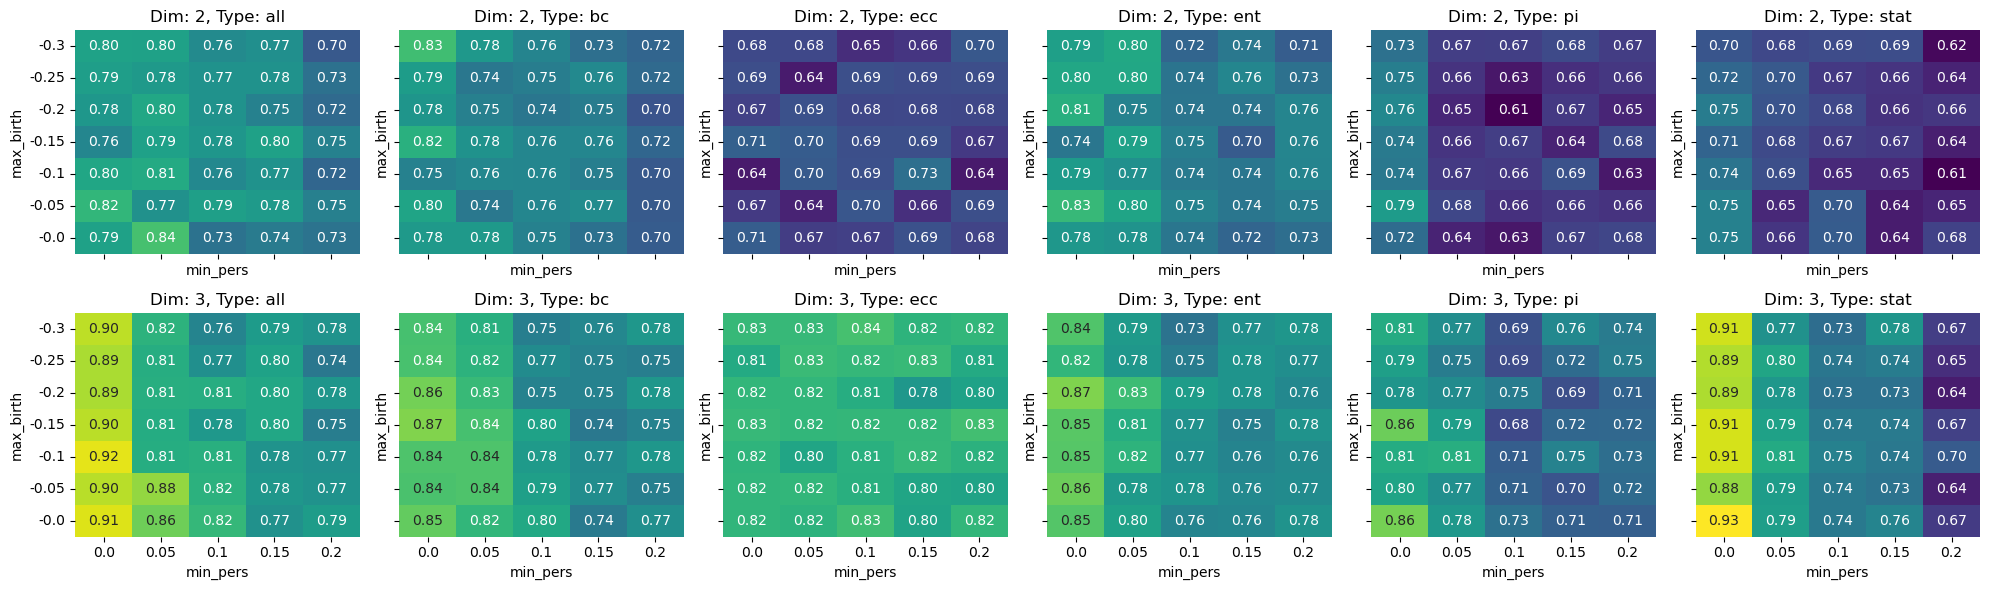

In [28]:
df_plot_grouped = df_class_airy.\
    drop(columns=['hash_train', 'hash_test', 'prefix', 'microscope']).\
    groupby(['dim', 'type', 'max_birth', 'min_pers']).mean().reset_index()
types = df_plot_grouped['type'].unique()
vmin = df_plot_grouped['accuracy_balanced'].min()
vmax = df_plot_grouped['accuracy_balanced'].max()

# le_type = LabelEncoder()
# unq_vals = np.unique(np.stack([df_plot_grouped['dim'].values,
#     le_type.fit_transform(df_plot_grouped['type'].values)]).T,
#     axis=0)
# unq_vals = unq_vals.astype(str)
# unq_vals[:,1] = le_type.inverse_transform(unq_vals[:,1].astype(int))


# Now plot the heatmaps
fig, ax = plt.subplots(2, len(types), figsize=(20, 6), sharex=True, sharey=True)

for dimi, dim in enumerate([2, 3]):
    for typei, type in enumerate(types):
        axi = (dimi, typei)

        # Plot the heatmap for each dimension and type
        df_plot = df_plot_grouped.loc[(df_plot_grouped['dim'] == dim) & (df_plot_grouped['type'] == type)].\
            pivot(index='max_birth', columns='min_pers', values='accuracy_balanced')

        sns.heatmap(df_plot, cmap='viridis',
                    annot=True, fmt='.2f',
                    vmin=vmin, vmax=vmax,
                    ax=ax[axi],
                    cbar=False)

        ax[axi].set_title(f'Dim: {dim}, Type: {type}')
    
fig.tight_layout()

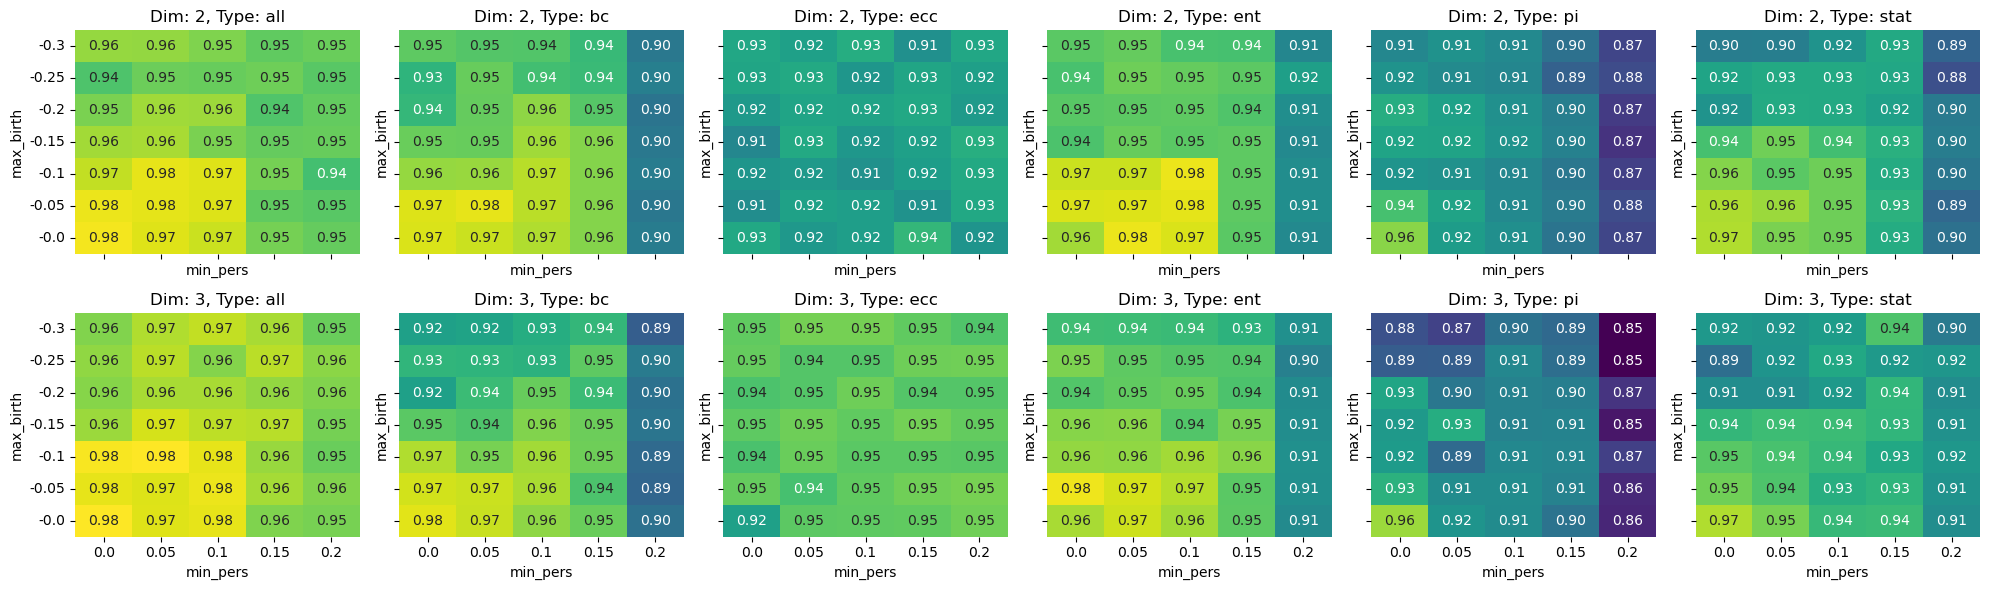

In [29]:
df_plot_grouped = df_class_sted.\
    drop(columns=['hash_train', 'hash_test', 'prefix', 'microscope']).\
    groupby(['dim', 'type', 'max_birth', 'min_pers']).mean().reset_index()
types = df_plot_grouped['type'].unique()
vmin = df_plot_grouped['accuracy_balanced'].min()
vmax = df_plot_grouped['accuracy_balanced'].max()

# le_type = LabelEncoder()
# unq_vals = np.unique(np.stack([df_plot_grouped['dim'].values,
#     le_type.fit_transform(df_plot_grouped['type'].values)]).T,
#     axis=0)
# unq_vals = unq_vals.astype(str)
# unq_vals[:,1] = le_type.inverse_transform(unq_vals[:,1].astype(int))


# Now plot the heatmaps
fig, ax = plt.subplots(2, len(types), figsize=(20, 6), sharex=True, sharey=True)

for dimi, dim in enumerate([2, 3]):
    for typei, type in enumerate(types):
        axi = (dimi, typei)

        # Plot the heatmap for each dimension and type
        df_plot = df_plot_grouped.loc[(df_plot_grouped['dim'] == dim) & (df_plot_grouped['type'] == type)].\
            pivot(index='max_birth', columns='min_pers', values='accuracy_balanced')

        sns.heatmap(df_plot, cmap='viridis',
                    annot=True, fmt='.2f',
                    vmin=vmin, vmax=vmax,
                    ax=ax[axi],
                    cbar=False)

        ax[axi].set_title(f'Dim: {dim}, Type: {type}')
    
fig.tight_layout()

#### old

In [ ]:
name = 'thresh-birth-000-pers-000_classification_airyscan_traintest_runs-10_perc-70_airyscan_clip_minmax_gaussian2c_minmax'

idx = name.index('birth')

birth_value = name[name.index('birth') + len('birth-'):].split('-')[0]
print(birth_value)

In [ ]:
class_files = sorted([file for file in classification_path.rglob('*classification*traintest_runs*.csv')
                      if preproc_choice in file.name
                       and 'airyscan' in file.name.lower()
                       and 'thresh' in file.name.lower()])
df_class_airy = []
for cli, classfilename in enumerate(class_files):
    name = classfilename.name
    df_tmp = pd.read_csv(classfilename)
    df_tmp.loc[:, 'max_birth'] = -np.float32(name[name.index('birth') + len('birth-'):].split('-')[0])/100
    df_tmp.loc[:, 'min_pers'] = np.float32(name[name.index('pers') + len('pers-'):].split('_')[0])/100
    df_class_airy.append(df_tmp.copy())

df_class_airy = pd.concat(df_class_airy)
df_class_airy = df_class_airy.sort_values(by=['dim', 'type', 'run'])

In [ ]:
df_plot = df_class_airy.\
    drop(columns=['hash_train', 'hash_test', 'prefix']).\
    groupby(['dim', 'type', 'max_birth', 'min_pers']).\
    agg(['mean', 'std']).\
    reset_index()

In [ ]:
df_plot = df_class_airy.melt(id_vars=['dim', 'type', 'max_birth', 'min_pers'],
                   value_vars=['accuracy_balanced'])

In [ ]:


df_plot_grouped = df_class_airy.\
    drop(columns=['hash_train', 'hash_test', 'prefix']).\
    groupby(['dim', 'type', 'max_birth', 'min_pers']).mean().reset_index()
types = df_plot_grouped['type'].unique()
vmin = df_plot_grouped['accuracy_balanced'].min()
vmax = df_plot_grouped['accuracy_balanced'].max()

# le_type = LabelEncoder()
# unq_vals = np.unique(np.stack([df_plot_grouped['dim'].values,
#     le_type.fit_transform(df_plot_grouped['type'].values)]).T,
#     axis=0)
# unq_vals = unq_vals.astype(str)
# unq_vals[:,1] = le_type.inverse_transform(unq_vals[:,1].astype(int))


# Now plot the heatmaps
fig, ax = plt.subplots(2, len(types), figsize=(20, 6), sharex=True, sharey=True)

for dimi, dim in enumerate([2, 3]):
    for typei, type in enumerate(types):
        axi = (dimi, typei)

        # Plot the heatmap for each dimension and type
        df_plot = df_plot_grouped.loc[(df_plot_grouped['dim'] == dim) & (df_plot_grouped['type'] == type)].\
            pivot(index='max_birth', columns='min_pers', values='accuracy_balanced')

        sns.heatmap(df_plot, cmap='viridis',
                    annot=True, fmt='.2f',
                    vmin=vmin, vmax=vmax,
                    ax=ax[axi],
                    cbar=False)

        ax[axi].set_title(f'Dim: {dim}, Type: {type}')
    
fig.tight_layout()

# Plots: Different thresholds on the persistence diagrams

### plot betti curves for showing the effect of thresholding

In [6]:
from src.auxfunctions import compute_hash, same_size_training, sanitize_persistence, drop_all_same, persistence_statistics

preprocessing = 'clip_minmax_gaussian2c_minmax'
df_labels = pd.read_csv(data_pers / 'labels_persistence_sted.csv')
labels = df_labels['labels'].values

invariant = 'bc'
cond = invariant

persfolder = pers_sted
savepath = classification_path
microscope=None
runs=10
train_percent='70'
run_start=0
persistence_threshold=None
birth_threshold=None
nameappend=''
saveasfile=False
n_jobs=6

if Path(persfolder).is_dir():
    pers_all, pers_keys = read_persistence_files(persfolder,
        preprocessing=preprocessing,
        return_keys=True)
    filename = np.unique([f.name[f.name.index('persistence'):]
                            for f in pers_keys[:,0] if 'persistence' in f.name])
    if len(filename) > 1:
        raise ValueError('More than one persistence file found')
    persfilename = Path(persfolder / filename[0])
else:
    raise ValueError('No persistence file found')

# get the splits
train_test_splits = same_size_training(labels, size=2*runs, train_size=int(train_percent)/100, seed=42)
hashes = np.array([[compute_hash(tt[0]), compute_hash(tt[1])] for tt in train_test_splits])

# now 
delete_idx = []
for i in range(len(hashes)):
    if hashes[i] in hashes[:i]:
        delete_idx.append(i)
train_test_splits = [train_test_splits[i] for i in range(len(train_test_splits)) if i not in delete_idx]
train_test_splits = train_test_splits[run_start:runs]
del hashes

assert len(train_test_splits) == runs - run_start

# now do the classification

results_tmp = []
for runk, train_test in tqdm(enumerate(train_test_splits),
                                total=len(train_test_splits),
                                smoothing=1):
    Xt_train = [[], []]
    Xt_test = [[], []]
    y_train = labels[train_test[0]]
    y_test = labels[train_test[1]]

    for prefix_dim in [2, 3]:
        train_idx = train_test[0]
        test_idx = train_test[1]
        resolution_pi=20
        bandwidth=4
        resolution_bc=250
        return_grid=True
        persistence_threshold = 0.05
        birth_threshold = -0.3
    
        assert 2 in pers_all.keys()
        assert 3 in pers_all.keys()
        assert invariant in ['stat', 'ent', 'bc', 'pi', 'ecc', 'all']
        assert prefix_dim in [2, 3]

        if return_grid:
            assert invariant in ['bc', 'ecc']

        X_train = []
        X_test = []
        y_train = labels[train_idx]
        y_test = labels[test_idx]

        if invariant != 'ecc':
            for dim in range(len(pers_all[prefix_dim])):
                data = pers_all[prefix_dim][dim]
                # data = [x[x[:, 1] != np.inf, :] for x in data]
                data = sanitize_persistence(data, min_pers=persistence_threshold,
                                            max_birth=birth_threshold)

                if invariant == 'stat': 
                    persstats, _ = persistence_statistics(data, return_names=True, lifespan=False)
                    
                    pers_st_train = persstats[train_idx, :]
                    if len(test_idx) > 0:
                        pers_st_test = persstats[test_idx, :]

                    idx_keep, pers_st_train = drop_all_same(pers_st_train)
                    if len(test_idx) > 0:
                        pers_st_test = pers_st_test[:, idx_keep]

                    X_train.append(pers_st_train)
                    if len(test_idx) > 0:
                        X_test.append(pers_st_test)

                elif invariant == 'ent':
                    ent = Entropy(mode='vector', normalized=False)
                    pers_ent_train = ent.fit_transform([data[i] for i in train_idx])
                    if len(test_idx) > 0:
                        pers_ent_test = ent.transform([data[i] for i in test_idx])

                    ent = Entropy(mode='scalar', normalized=False)
                    pers_ent_train = np.hstack([ent.fit_transform([data[i] for i in train_idx]),
                                            pers_ent_train])
                    if len(test_idx) > 0:
                        pers_ent_test = np.hstack([ent.transform([data[i] for i in test_idx]),
                                                pers_ent_test])

                    idx_keep, pers_ent_train = drop_all_same(pers_ent_train)
                    if len(test_idx) > 0:
                        pers_ent_test = pers_ent_test[:, idx_keep]

                    X_train.append(pers_ent_train)
                    if len(test_idx) > 0:
                        X_test.append(pers_ent_test)
                
                elif invariant == 'bc':
                    inv_bc = BettiCurve(resolution=resolution_bc)
                    pers_bc_train = inv_bc.fit_transform([data[i] for i in train_idx])
                    if len(test_idx) > 0:
                        pers_bc_test = inv_bc.transform([data[i] for i in test_idx])

                    idx_keep, pers_bc_train = drop_all_same(pers_bc_train)
                    if len(test_idx) > 0:
                        pers_bc_test = pers_bc_test[:, idx_keep]

                    X_train.append(pers_bc_train)
                    if len(test_idx) > 0:
                        X_test.append(pers_bc_test)

                    if return_grid:
                        grid = inv_bc.grid_
                
                elif invariant == 'pi':
                    inv_pi = PersistenceImage(bandwidth=bandwidth,
                            resolution=[resolution_pi, resolution_pi])
                    pers_pi_train = inv_pi.fit_transform([data[i] for i in train_idx])
                    if len(test_idx) > 0:
                        pers_pi_test = inv_pi.transform([data[i] for i in test_idx])

                    idx_keep, pers_pi_train = drop_all_same(pers_pi_train)
                    if len(test_idx) > 0:
                        pers_pi_test = pers_pi_test[:, idx_keep]

                    X_train.append(pers_pi_train)
                    if len(test_idx) > 0:
                        X_test.append(pers_pi_test)
            X_train = np.hstack(X_train)
            if len(test_idx) > 0:
                X_test = np.hstack(X_test)
            else:
                X_test = np.array([])
        else:
            raise ValueError('Invalid invariant')

        # print('intermed', np.shape(X_train), np.shape(X_test), cond, prefix_dim)

    #     ss = StandardScaler()
    #     X_train = ss.fit_transform(X_train)
    #     X_test = ss.transform(X_test)

    #     # We can also use SimpleImputer etc
    #     # remove rows if they contain more than 20% of nan values

    #     # if np.any(np.isnan(X_train)) or np.any(np.isnan(X_test)):
    #     #     nanidx = np.all(np.isnan(X_train), axis=1)
    #     #     if np.any(nanidx):
    #     #         print('Dropping nan rows', np.sum(nanidx), cond)
    #     #         X_train = X_train[~nanidx, :]
    #     #         y_train = y_train[~nanidx]

    #     #     nanidx = np.all(np.isnan(X_test), axis=1)
    #     #     if np.any(nanidx):
    #     #         print('Dropping nan rows', np.sum(nanidx), cond)
    #     #         X_test = X_test[~nanidx, :]
    #     #         y_test = y_test[~nanidx]
        
    #     # if np.count_nonzero(np.sum(np.isnan(X_train), axis=1)) < 2:
    #     #     if np.sum(np.isnan(X_train), axis=1).max() > 10:
    #     #         # print('Dropping nan rows', np.sum(np.isnan(X_train), axis=1))
    #     #         idx_remain = ~np.any(np.isnan(X_train), axis=1)
    #     #         X_train = X_train[idx_remain, :]
    #     #         y_train = y_train[idx_remain]

        drop_col = np.unique(np.where(np.isnan(X_train))[1])
        if len(drop_col) > 0:
            print('Dropping nan columns', drop_col, cond)
            remaining_col = np.sum(np.isnan(X_train), axis=0) == 0
            X_train = X_train[:, remaining_col]
            X_test = X_test[:, remaining_col]

        idx_fill = np.where(np.abs(X_test) >= np.finfo(np.float32).max)
        X_test[idx_fill] = np.nanmean(X_train[:, np.unique(idx_fill[1])], axis=0)
        idx_fill = np.where(np.isnan(X_test))
        X_test[idx_fill] = np.nanmean(X_train[:, np.unique(idx_fill[1])], axis=0)

        if len(X_train.shape) == 0 or len(X_test.shape) == 0:
            print(np.shape(X_train), np.shape(X_test), cond)
            print(np.any(np.isnan(X_train)), np.any(np.isnan(X_test)))
            print('EMPTY training/test set', cond, persfilename.name)
            continue

        Xt_train[prefix_dim - 2].append(X_train.copy())
        Xt_test[prefix_dim - 2].append(X_test.copy())

    # # now do the Classification via GridSearch
    # if np.any(np.isnan(X_train)) or np.any(np.isnan(X_test)):
    #     print('NaN in training/test set', cond, persfilename.name)
    #     continue
    # print('run', run_start, ', vectorization:', cond, ', dim:', prefix_dim,
    #         ', shape:', np.shape(X_train), np.shape(X_test))
    break
                
                

  0%|          | 0/10 [00:00<?, ?it/s]

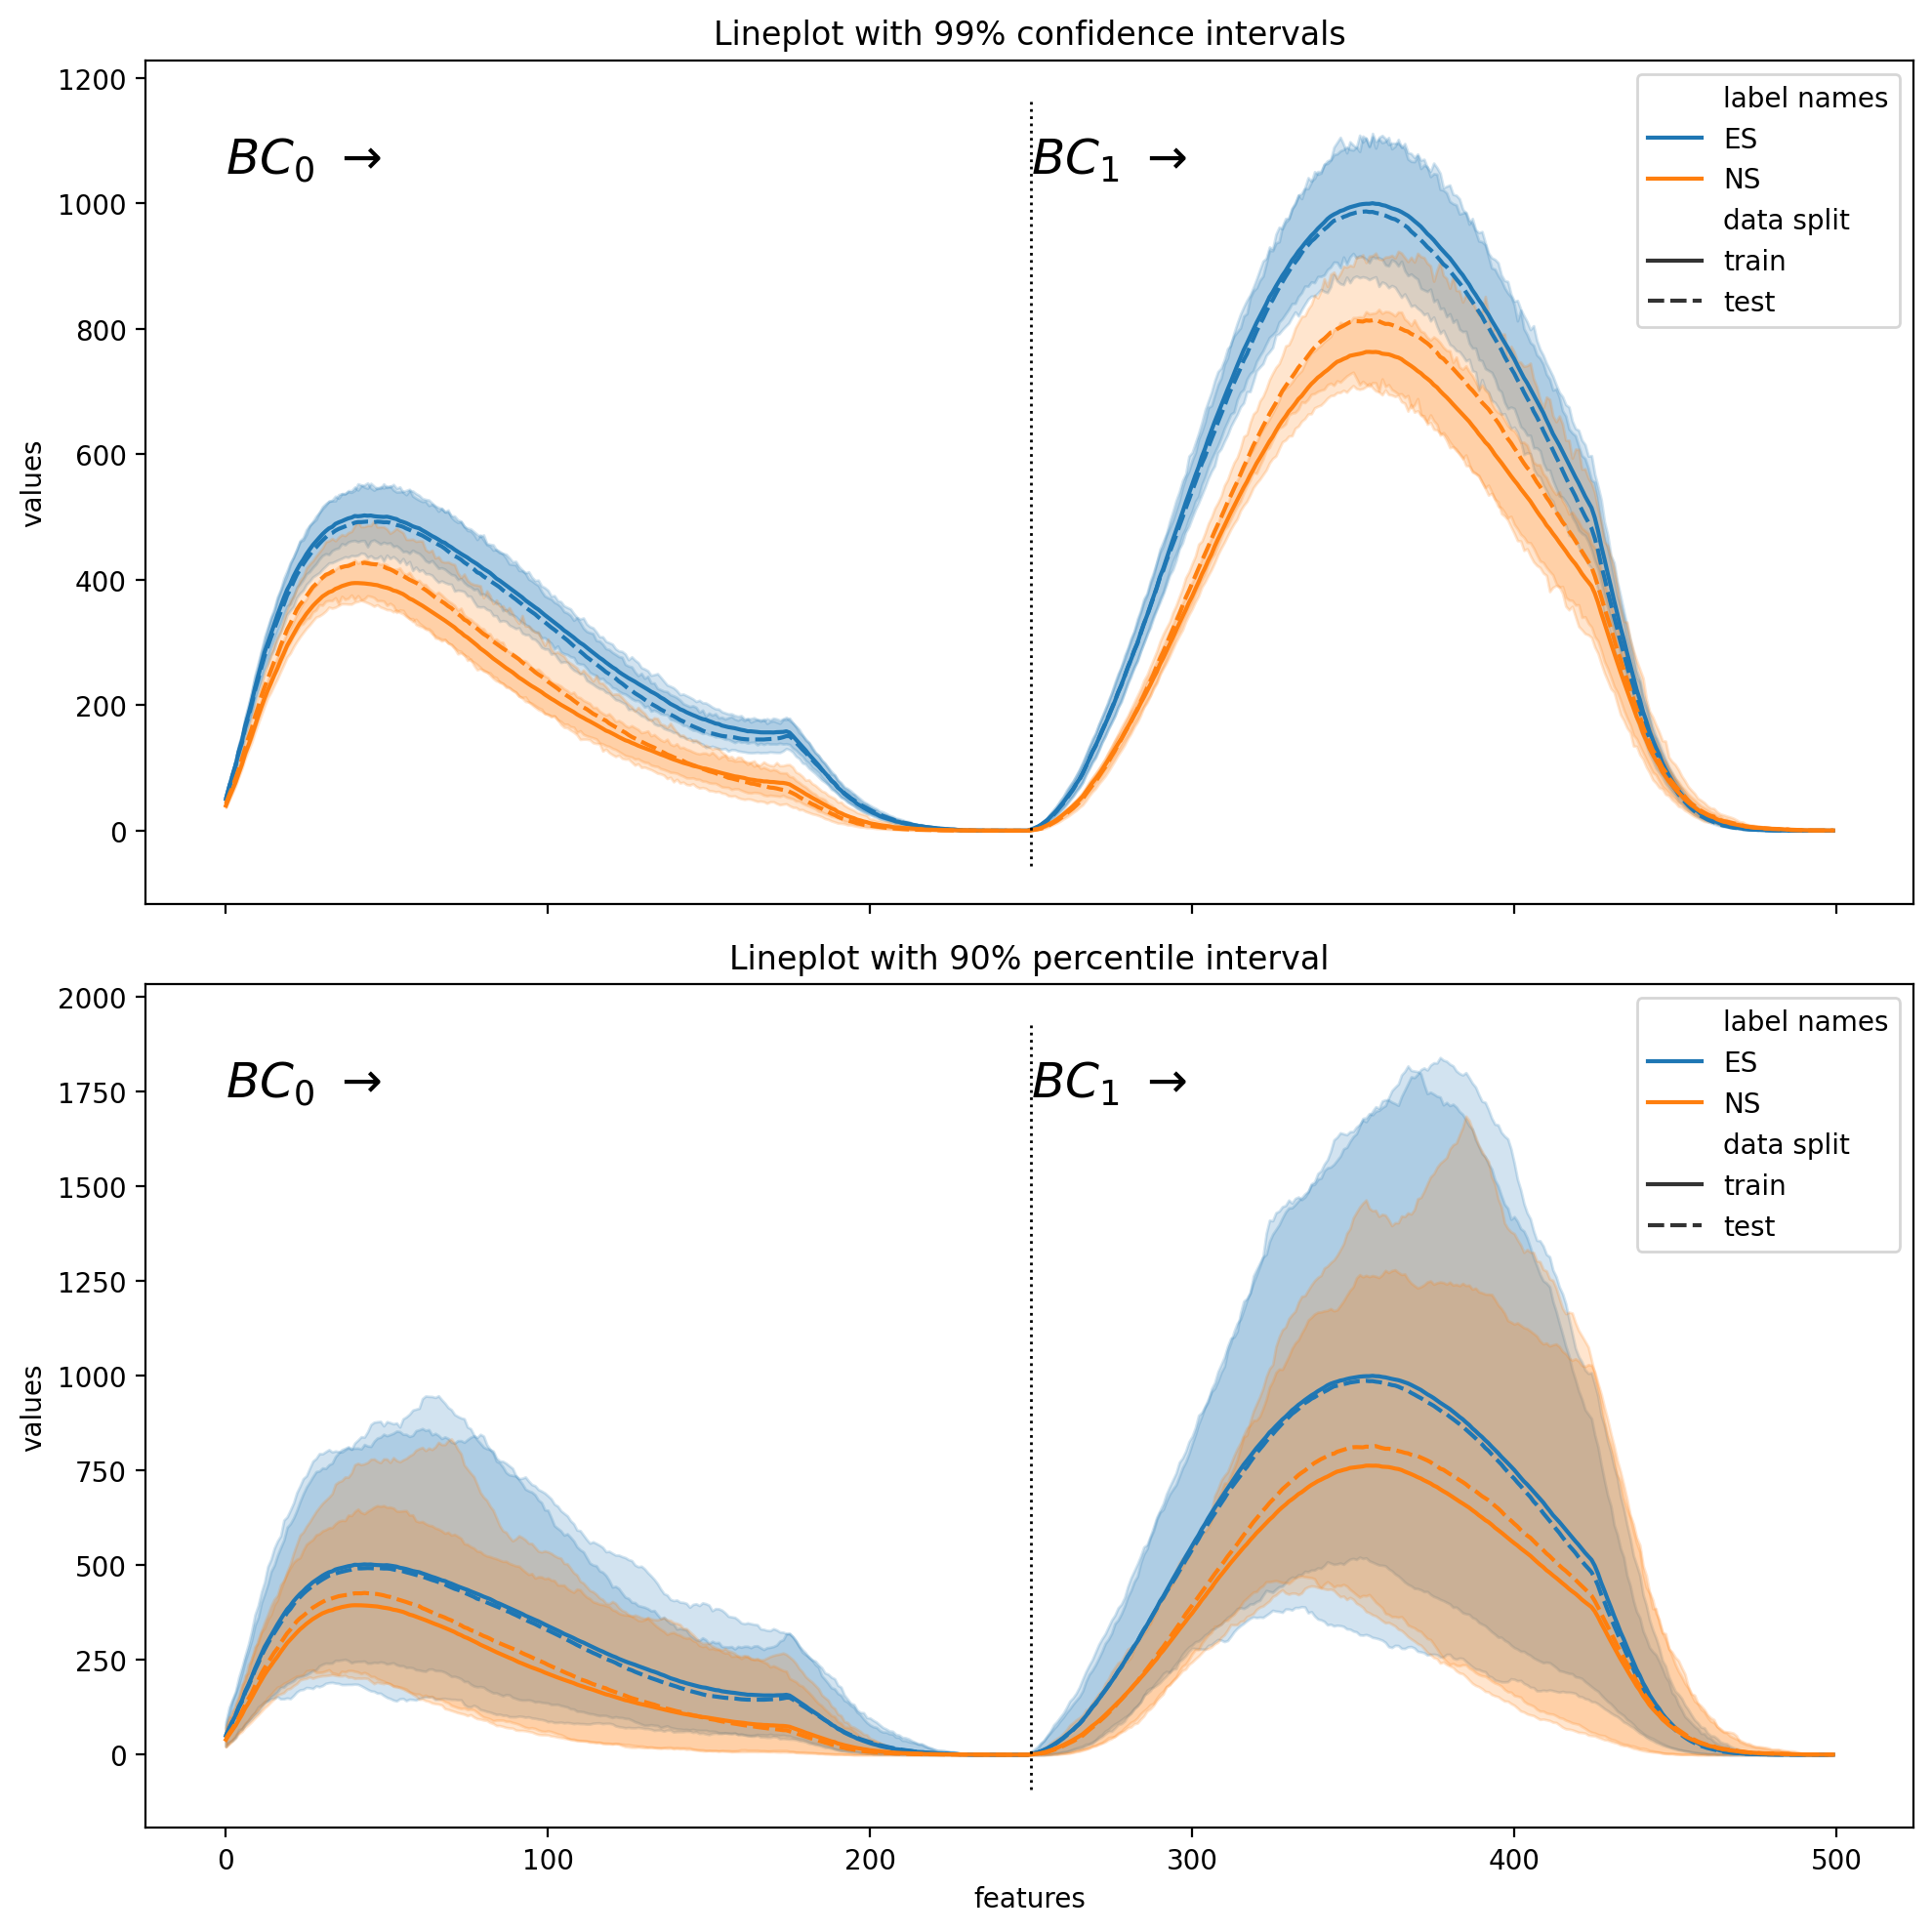

In [25]:
dim = 2
dim = dim -2

df_plot = pd.DataFrame(np.vstack([Xt_train[dim][0], Xt_test[dim][0]]),
                       columns=np.arange(Xt_train[dim][0].shape[1]))
# df_plot['labels'] = np.hstack([y_train, y_test]).astype(np.int32)
# df_plot['train'] = np.hstack([np.ones(len(y_train)), np.zeros(len(y_test))]).astype(np.int32)

df_plot.loc[:, 'label names'] = ['ES' if x == 0 else 'NS'
    for x in np.hstack([y_train, y_test]).astype(np.int32)]
df_plot.loc[:, 'data split'] = ['test' if x == 0 else 'train'
    for x in np.hstack([np.ones(len(y_train)), np.zeros(len(y_test))]).astype(np.int32)]

df_melt = df_plot.melt(id_vars=['label names', 'data split'],
                       var_name='features', value_name='values')

fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=200, sharex=True)
sns.lineplot(data=df_melt, x='features', y='values',
             hue='label names', style='data split',
             errorbar=('ci', 99), ax=ax[0])
sns.lineplot(data=df_melt, x='features', y='values',
             hue='label names', style='data split',
             errorbar=('pi', 90), ax=ax[1])

dim_borders = [np.shape(Xt_train[dim][0])[1]/(dim+2) * j 
               for j in range(dim+2 + 1)]
dim_textplacement = [0.1 * (dim_borders[i+1] - dim_borders[i+1]) + dim_borders[i]
                     for i in range(len(dim_borders)-1)]

for i in range(len(ax)):
    for j in range(dim + 2):
        ax[i].text(dim_textplacement[j], 0.95 * ax[i].get_ylim()[1],
                 fr'$BC_{j} ~\rightarrow$', fontsize=18,
                 ha='left', va='top', color='black')
        if j > 0:
            ax[i].vlines(np.shape(Xt_train[dim][0])[1]//(dim+2) * j,
                        ax[i].get_ylim()[0], ax[i].get_ylim()[1],
                        color='black', ls='dotted', lw=1)
        
ax[0].set_title('Lineplot with 99% confidence intervals')
ax[1].set_title('Lineplot with 90% percentile interval')
fig.tight_layout()

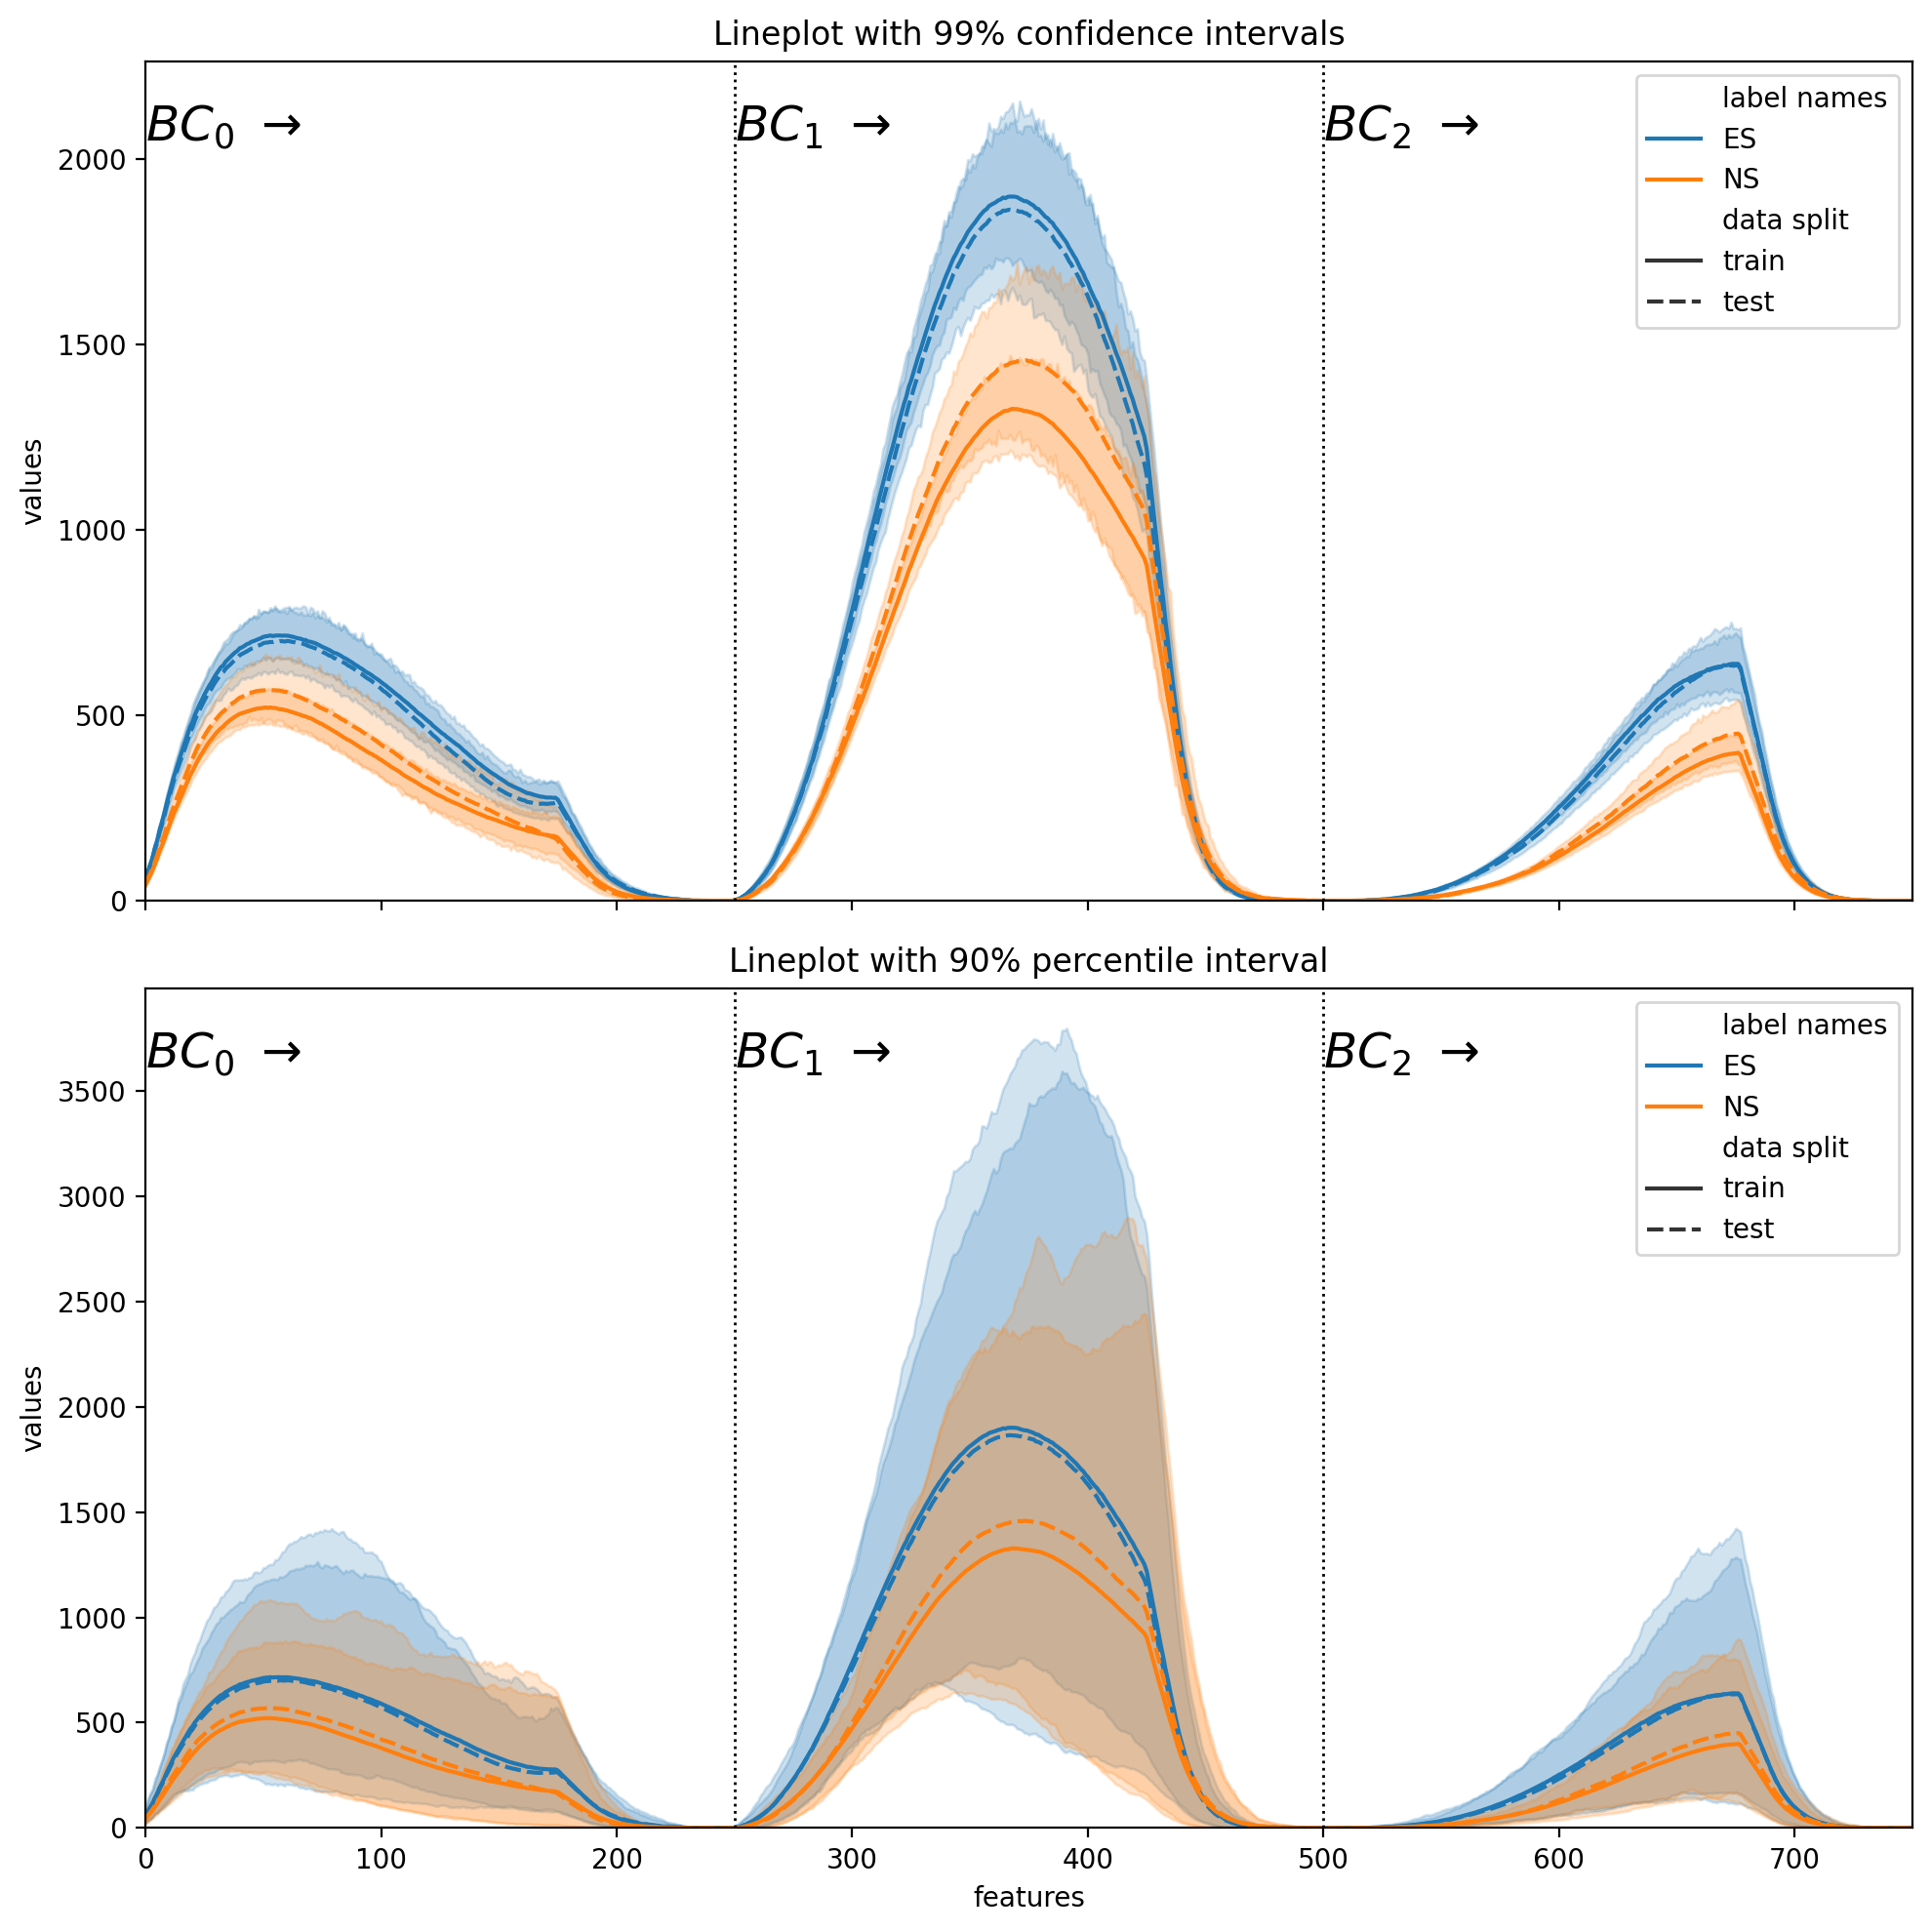

In [26]:
dim = 3
dim = dim -2

df_plot = pd.DataFrame(np.vstack([Xt_train[dim][0], Xt_test[dim][0]]),
                       columns=np.arange(Xt_train[dim][0].shape[1]))
# df_plot['labels'] = np.hstack([y_train, y_test])
# df_plot['train'] = np.hstack([np.ones(len(y_train)), np.zeros(len(y_test))])

# df_melt = df_plot.melt(id_vars=['labels', 'train'], var_name='features', value_name='values')
df_plot.loc[:, 'label names'] = ['ES' if x == 0 else 'NS'
    for x in np.hstack([y_train, y_test]).astype(np.int32)]
df_plot.loc[:, 'data split'] = ['test' if x == 0 else 'train'
    for x in np.hstack([np.ones(len(y_train)), np.zeros(len(y_test))]).astype(np.int32)]

df_melt = df_plot.melt(id_vars=['label names', 'data split'],
                       var_name='features', value_name='values')

fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=200, sharex=True)
sns.lineplot(data=df_melt, x='features', y='values',
             hue='label names', style='data split',
             errorbar=('ci', 99), ax=ax[0])
sns.lineplot(data=df_melt, x='features', y='values',
             hue='label names', style='data split',
             errorbar=('pi', 90), ax=ax[1])

dim_borders = [np.shape(Xt_train[dim][0])[1]/(dim+2) * j 
               for j in range(dim+2 + 1)]
dim_textplacement = [0.1 * (dim_borders[i+1] - dim_borders[i+1]) + dim_borders[i]
                     for i in range(len(dim_borders)-1)]

for i in range(len(ax)):
    ax[i].set_xlim(0, np.shape(Xt_train[dim][0])[1])
    ax[i].set_ylim(0, ax[i].get_ylim()[1])
    for j in range(dim + 2):
        ax[i].text(dim_textplacement[j], 0.95 * ax[i].get_ylim()[1],
                 fr'$BC_{j} ~\rightarrow$', fontsize=18,
                 ha='left', va='top', color='black')
        if j > 0:
            ax[i].vlines(np.shape(Xt_train[dim][0])[1]//(dim+2) * j,
                        ax[i].get_ylim()[0], ax[i].get_ylim()[1],
                        color='black', ls='dotted', lw=1)

ax[0].set_title('Lineplot with 99% confidence intervals')
ax[1].set_title('Lineplot with 90% percentile interval')
fig.tight_layout()


### Airyscan

In [32]:
from src.auxfunctions import compute_hash, same_size_training, sanitize_persistence, drop_all_same, persistence_statistics

preprocessing = 'clip_minmax_gaussian2c_minmax'
df_labels = pd.read_csv(data_pers / 'labels_persistence_airyscan.csv')
labels = df_labels['labels'].values

invariant = 'bc'
cond = invariant

persfolder = pers_airyscan
savepath = classification_path
microscope=None
runs=10
train_percent='70'
run_start=0
persistence_threshold=None
birth_threshold=None
nameappend=''
saveasfile=False
n_jobs=6

if Path(persfolder).is_dir():
    pers_all, pers_keys = read_persistence_files(persfolder,
        preprocessing=preprocessing,
        return_keys=True)
    filename = np.unique([f.name[f.name.index('persistence'):]
                            for f in pers_keys[:,0] if 'persistence' in f.name])
    if len(filename) > 1:
        raise ValueError('More than one persistence file found')
    persfilename = Path(persfolder / filename[0])
else:
    raise ValueError('No persistence file found')

# get the splits
train_test_splits = same_size_training(labels, size=2*runs, train_size=int(train_percent)/100, seed=42)
hashes = np.array([[compute_hash(tt[0]), compute_hash(tt[1])] for tt in train_test_splits])

# now 
delete_idx = []
for i in range(len(hashes)):
    if hashes[i] in hashes[:i]:
        delete_idx.append(i)
train_test_splits = [train_test_splits[i] for i in range(len(train_test_splits)) if i not in delete_idx]
train_test_splits = train_test_splits[run_start:runs]
del hashes

assert len(train_test_splits) == runs - run_start

# now do the classification

results_tmp = []
for runk, train_test in tqdm(enumerate(train_test_splits),
                                total=len(train_test_splits),
                                smoothing=1):
    Xt_train = [[], []]
    Xt_test = [[], []]
    y_train = labels[train_test[0]]
    y_test = labels[train_test[1]]

    for prefix_dim in [2, 3]:
        train_idx = train_test[0]
        test_idx = train_test[1]
        resolution_pi=20
        bandwidth=4
        resolution_bc=250
        return_grid=True
        persistence_threshold = 0.05
        birth_threshold = -0.3
    
        assert 2 in pers_all.keys()
        assert 3 in pers_all.keys()
        assert invariant in ['stat', 'ent', 'bc', 'pi', 'ecc', 'all']
        assert prefix_dim in [2, 3]

        if return_grid:
            assert invariant in ['bc', 'ecc']

        X_train = []
        X_test = []
        y_train = labels[train_idx]
        y_test = labels[test_idx]

        if invariant != 'ecc':
            for dim in range(len(pers_all[prefix_dim])):
                data = pers_all[prefix_dim][dim]
                # data = [x[x[:, 1] != np.inf, :] for x in data]
                data = sanitize_persistence(data, min_pers=persistence_threshold,
                                            max_birth=birth_threshold)

                if invariant == 'stat': 
                    persstats, _ = persistence_statistics(data, return_names=True, lifespan=False)
                    
                    pers_st_train = persstats[train_idx, :]
                    if len(test_idx) > 0:
                        pers_st_test = persstats[test_idx, :]

                    idx_keep, pers_st_train = drop_all_same(pers_st_train)
                    if len(test_idx) > 0:
                        pers_st_test = pers_st_test[:, idx_keep]

                    X_train.append(pers_st_train)
                    if len(test_idx) > 0:
                        X_test.append(pers_st_test)

                elif invariant == 'ent':
                    ent = Entropy(mode='vector', normalized=False)
                    pers_ent_train = ent.fit_transform([data[i] for i in train_idx])
                    if len(test_idx) > 0:
                        pers_ent_test = ent.transform([data[i] for i in test_idx])

                    ent = Entropy(mode='scalar', normalized=False)
                    pers_ent_train = np.hstack([ent.fit_transform([data[i] for i in train_idx]),
                                            pers_ent_train])
                    if len(test_idx) > 0:
                        pers_ent_test = np.hstack([ent.transform([data[i] for i in test_idx]),
                                                pers_ent_test])

                    idx_keep, pers_ent_train = drop_all_same(pers_ent_train)
                    if len(test_idx) > 0:
                        pers_ent_test = pers_ent_test[:, idx_keep]

                    X_train.append(pers_ent_train)
                    if len(test_idx) > 0:
                        X_test.append(pers_ent_test)
                
                elif invariant == 'bc':
                    inv_bc = BettiCurve(resolution=resolution_bc)
                    pers_bc_train = inv_bc.fit_transform([data[i] for i in train_idx])
                    if len(test_idx) > 0:
                        pers_bc_test = inv_bc.transform([data[i] for i in test_idx])

                    idx_keep, pers_bc_train = drop_all_same(pers_bc_train)
                    if len(test_idx) > 0:
                        pers_bc_test = pers_bc_test[:, idx_keep]

                    X_train.append(pers_bc_train)
                    if len(test_idx) > 0:
                        X_test.append(pers_bc_test)

                    if return_grid:
                        grid = inv_bc.grid_
                
                elif invariant == 'pi':
                    inv_pi = PersistenceImage(bandwidth=bandwidth,
                            resolution=[resolution_pi, resolution_pi])
                    pers_pi_train = inv_pi.fit_transform([data[i] for i in train_idx])
                    if len(test_idx) > 0:
                        pers_pi_test = inv_pi.transform([data[i] for i in test_idx])

                    idx_keep, pers_pi_train = drop_all_same(pers_pi_train)
                    if len(test_idx) > 0:
                        pers_pi_test = pers_pi_test[:, idx_keep]

                    X_train.append(pers_pi_train)
                    if len(test_idx) > 0:
                        X_test.append(pers_pi_test)
            X_train = np.hstack(X_train)
            if len(test_idx) > 0:
                X_test = np.hstack(X_test)
            else:
                X_test = np.array([])
        else:
            raise ValueError('Invalid invariant')

        # print('intermed', np.shape(X_train), np.shape(X_test), cond, prefix_dim)

    #     ss = StandardScaler()
    #     X_train = ss.fit_transform(X_train)
    #     X_test = ss.transform(X_test)

    #     # We can also use SimpleImputer etc
    #     # remove rows if they contain more than 20% of nan values

    #     # if np.any(np.isnan(X_train)) or np.any(np.isnan(X_test)):
    #     #     nanidx = np.all(np.isnan(X_train), axis=1)
    #     #     if np.any(nanidx):
    #     #         print('Dropping nan rows', np.sum(nanidx), cond)
    #     #         X_train = X_train[~nanidx, :]
    #     #         y_train = y_train[~nanidx]

    #     #     nanidx = np.all(np.isnan(X_test), axis=1)
    #     #     if np.any(nanidx):
    #     #         print('Dropping nan rows', np.sum(nanidx), cond)
    #     #         X_test = X_test[~nanidx, :]
    #     #         y_test = y_test[~nanidx]
        
    #     # if np.count_nonzero(np.sum(np.isnan(X_train), axis=1)) < 2:
    #     #     if np.sum(np.isnan(X_train), axis=1).max() > 10:
    #     #         # print('Dropping nan rows', np.sum(np.isnan(X_train), axis=1))
    #     #         idx_remain = ~np.any(np.isnan(X_train), axis=1)
    #     #         X_train = X_train[idx_remain, :]
    #     #         y_train = y_train[idx_remain]

        drop_col = np.unique(np.where(np.isnan(X_train))[1])
        if len(drop_col) > 0:
            print('Dropping nan columns', drop_col, cond)
            remaining_col = np.sum(np.isnan(X_train), axis=0) == 0
            X_train = X_train[:, remaining_col]
            X_test = X_test[:, remaining_col]

        idx_fill = np.where(np.abs(X_test) >= np.finfo(np.float32).max)
        X_test[idx_fill] = np.nanmean(X_train[:, np.unique(idx_fill[1])], axis=0)
        idx_fill = np.where(np.isnan(X_test))
        X_test[idx_fill] = np.nanmean(X_train[:, np.unique(idx_fill[1])], axis=0)

        if len(X_train.shape) == 0 or len(X_test.shape) == 0:
            print(np.shape(X_train), np.shape(X_test), cond)
            print(np.any(np.isnan(X_train)), np.any(np.isnan(X_test)))
            print('EMPTY training/test set', cond, persfilename.name)
            continue

        Xt_train[prefix_dim - 2].append(X_train.copy())
        Xt_test[prefix_dim - 2].append(X_test.copy())

    # # now do the Classification via GridSearch
    # if np.any(np.isnan(X_train)) or np.any(np.isnan(X_test)):
    #     print('NaN in training/test set', cond, persfilename.name)
    #     continue
    # print('run', run_start, ', vectorization:', cond, ', dim:', prefix_dim,
    #         ', shape:', np.shape(X_train), np.shape(X_test))
    break
                
                

  0%|          | 0/10 [00:00<?, ?it/s]

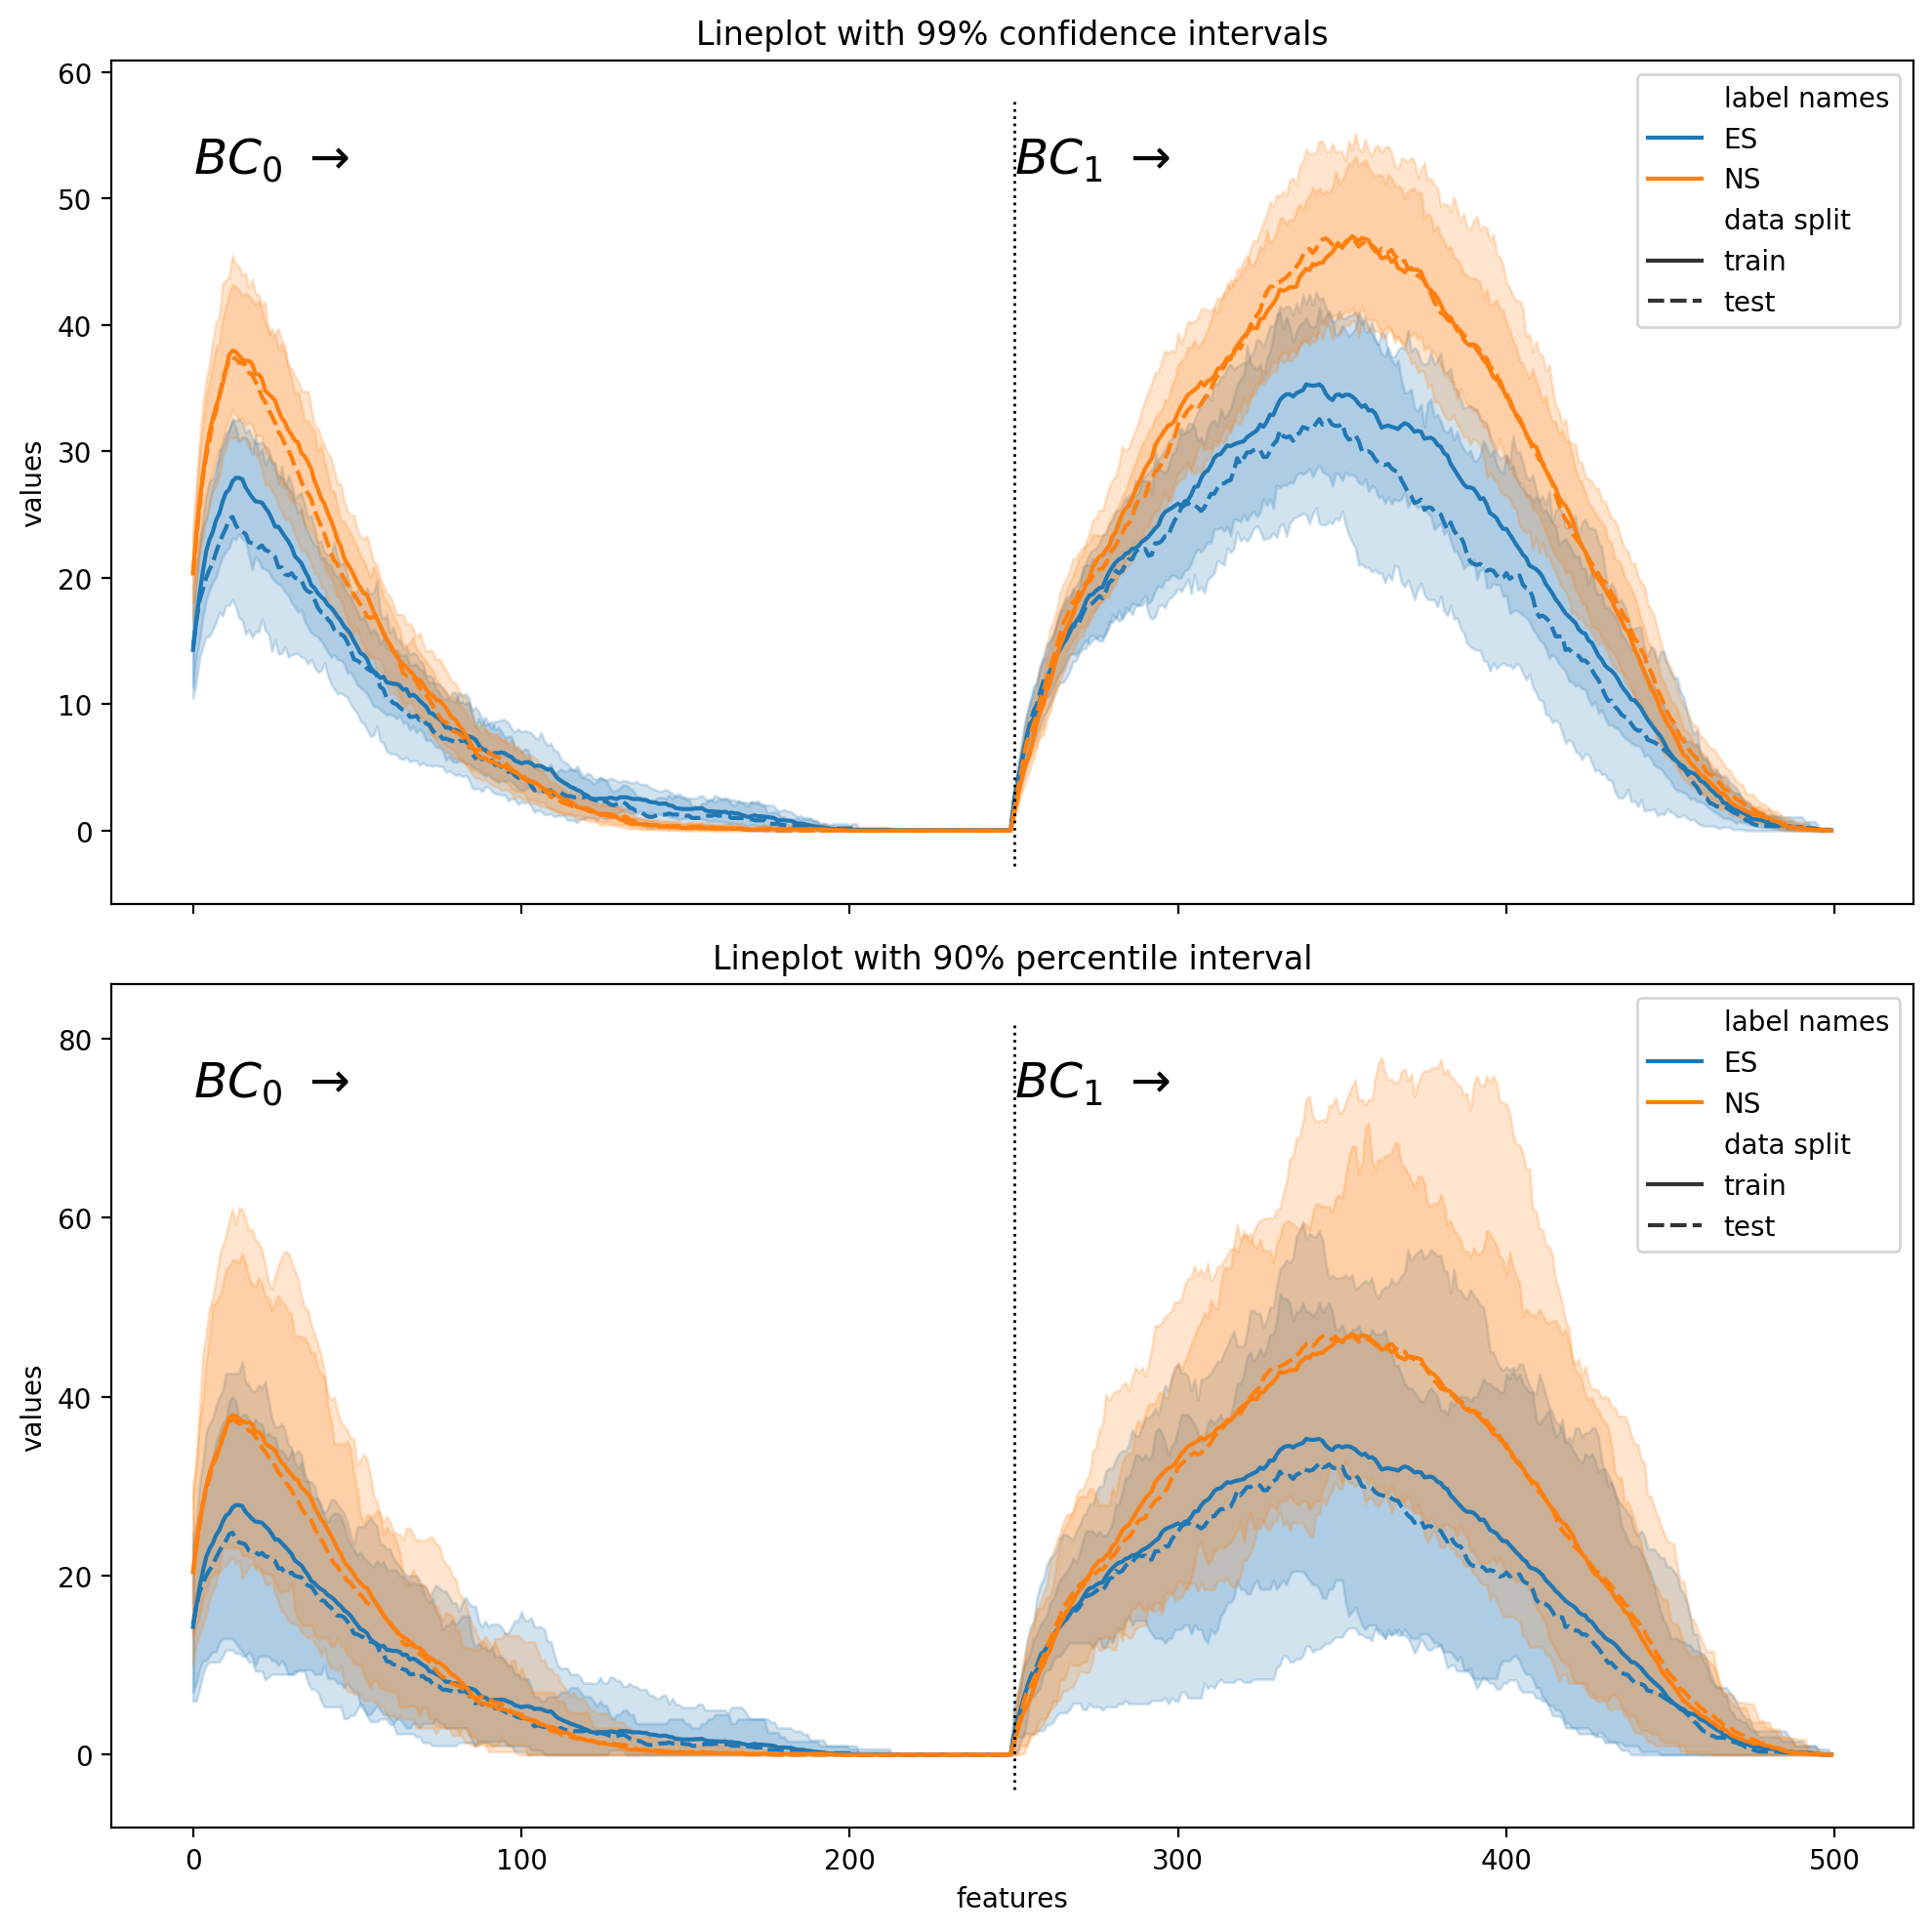

In [34]:
dim = 2
dim = dim -2

df_plot = pd.DataFrame(np.vstack([Xt_train[dim][0], Xt_test[dim][0]]),
                       columns=np.arange(Xt_train[dim][0].shape[1]))
# df_plot['labels'] = np.hstack([y_train, y_test]).astype(np.int32)
# df_plot['train'] = np.hstack([np.ones(len(y_train)), np.zeros(len(y_test))]).astype(np.int32)

df_plot.loc[:, 'label names'] = ['ES' if x == 0 else 'NS'
    for x in np.hstack([y_train, y_test]).astype(np.int32)]
df_plot.loc[:, 'data split'] = ['test' if x == 0 else 'train'
    for x in np.hstack([np.ones(len(y_train)), np.zeros(len(y_test))]).astype(np.int32)]

df_melt = df_plot.melt(id_vars=['label names', 'data split'],
                       var_name='features', value_name='values')

fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=200, sharex=True)
sns.lineplot(data=df_melt, x='features', y='values',
             hue='label names', style='data split',
             errorbar=('ci', 99), ax=ax[0])
sns.lineplot(data=df_melt, x='features', y='values',
             hue='label names', style='data split',
             errorbar=('pi', 90), ax=ax[1])

dim_borders = [np.shape(Xt_train[dim][0])[1]/(dim+2) * j 
               for j in range(dim+2 + 1)]
dim_textplacement = [0.1 * (dim_borders[i+1] - dim_borders[i+1]) + dim_borders[i]
                     for i in range(len(dim_borders)-1)]

for i in range(len(ax)):
    for j in range(dim + 2):
        ax[i].text(dim_textplacement[j], 0.95 * ax[i].get_ylim()[1],
                 fr'$BC_{j} ~\rightarrow$', fontsize=18,
                 ha='left', va='top', color='black')
        if j > 0:
            ax[i].vlines(np.shape(Xt_train[dim][0])[1]//(dim+2) * j,
                        ax[i].get_ylim()[0], ax[i].get_ylim()[1],
                        color='black', ls='dotted', lw=1)
        
ax[0].set_title('Lineplot with 99% confidence intervals')
ax[1].set_title('Lineplot with 90% percentile interval')
fig.tight_layout()

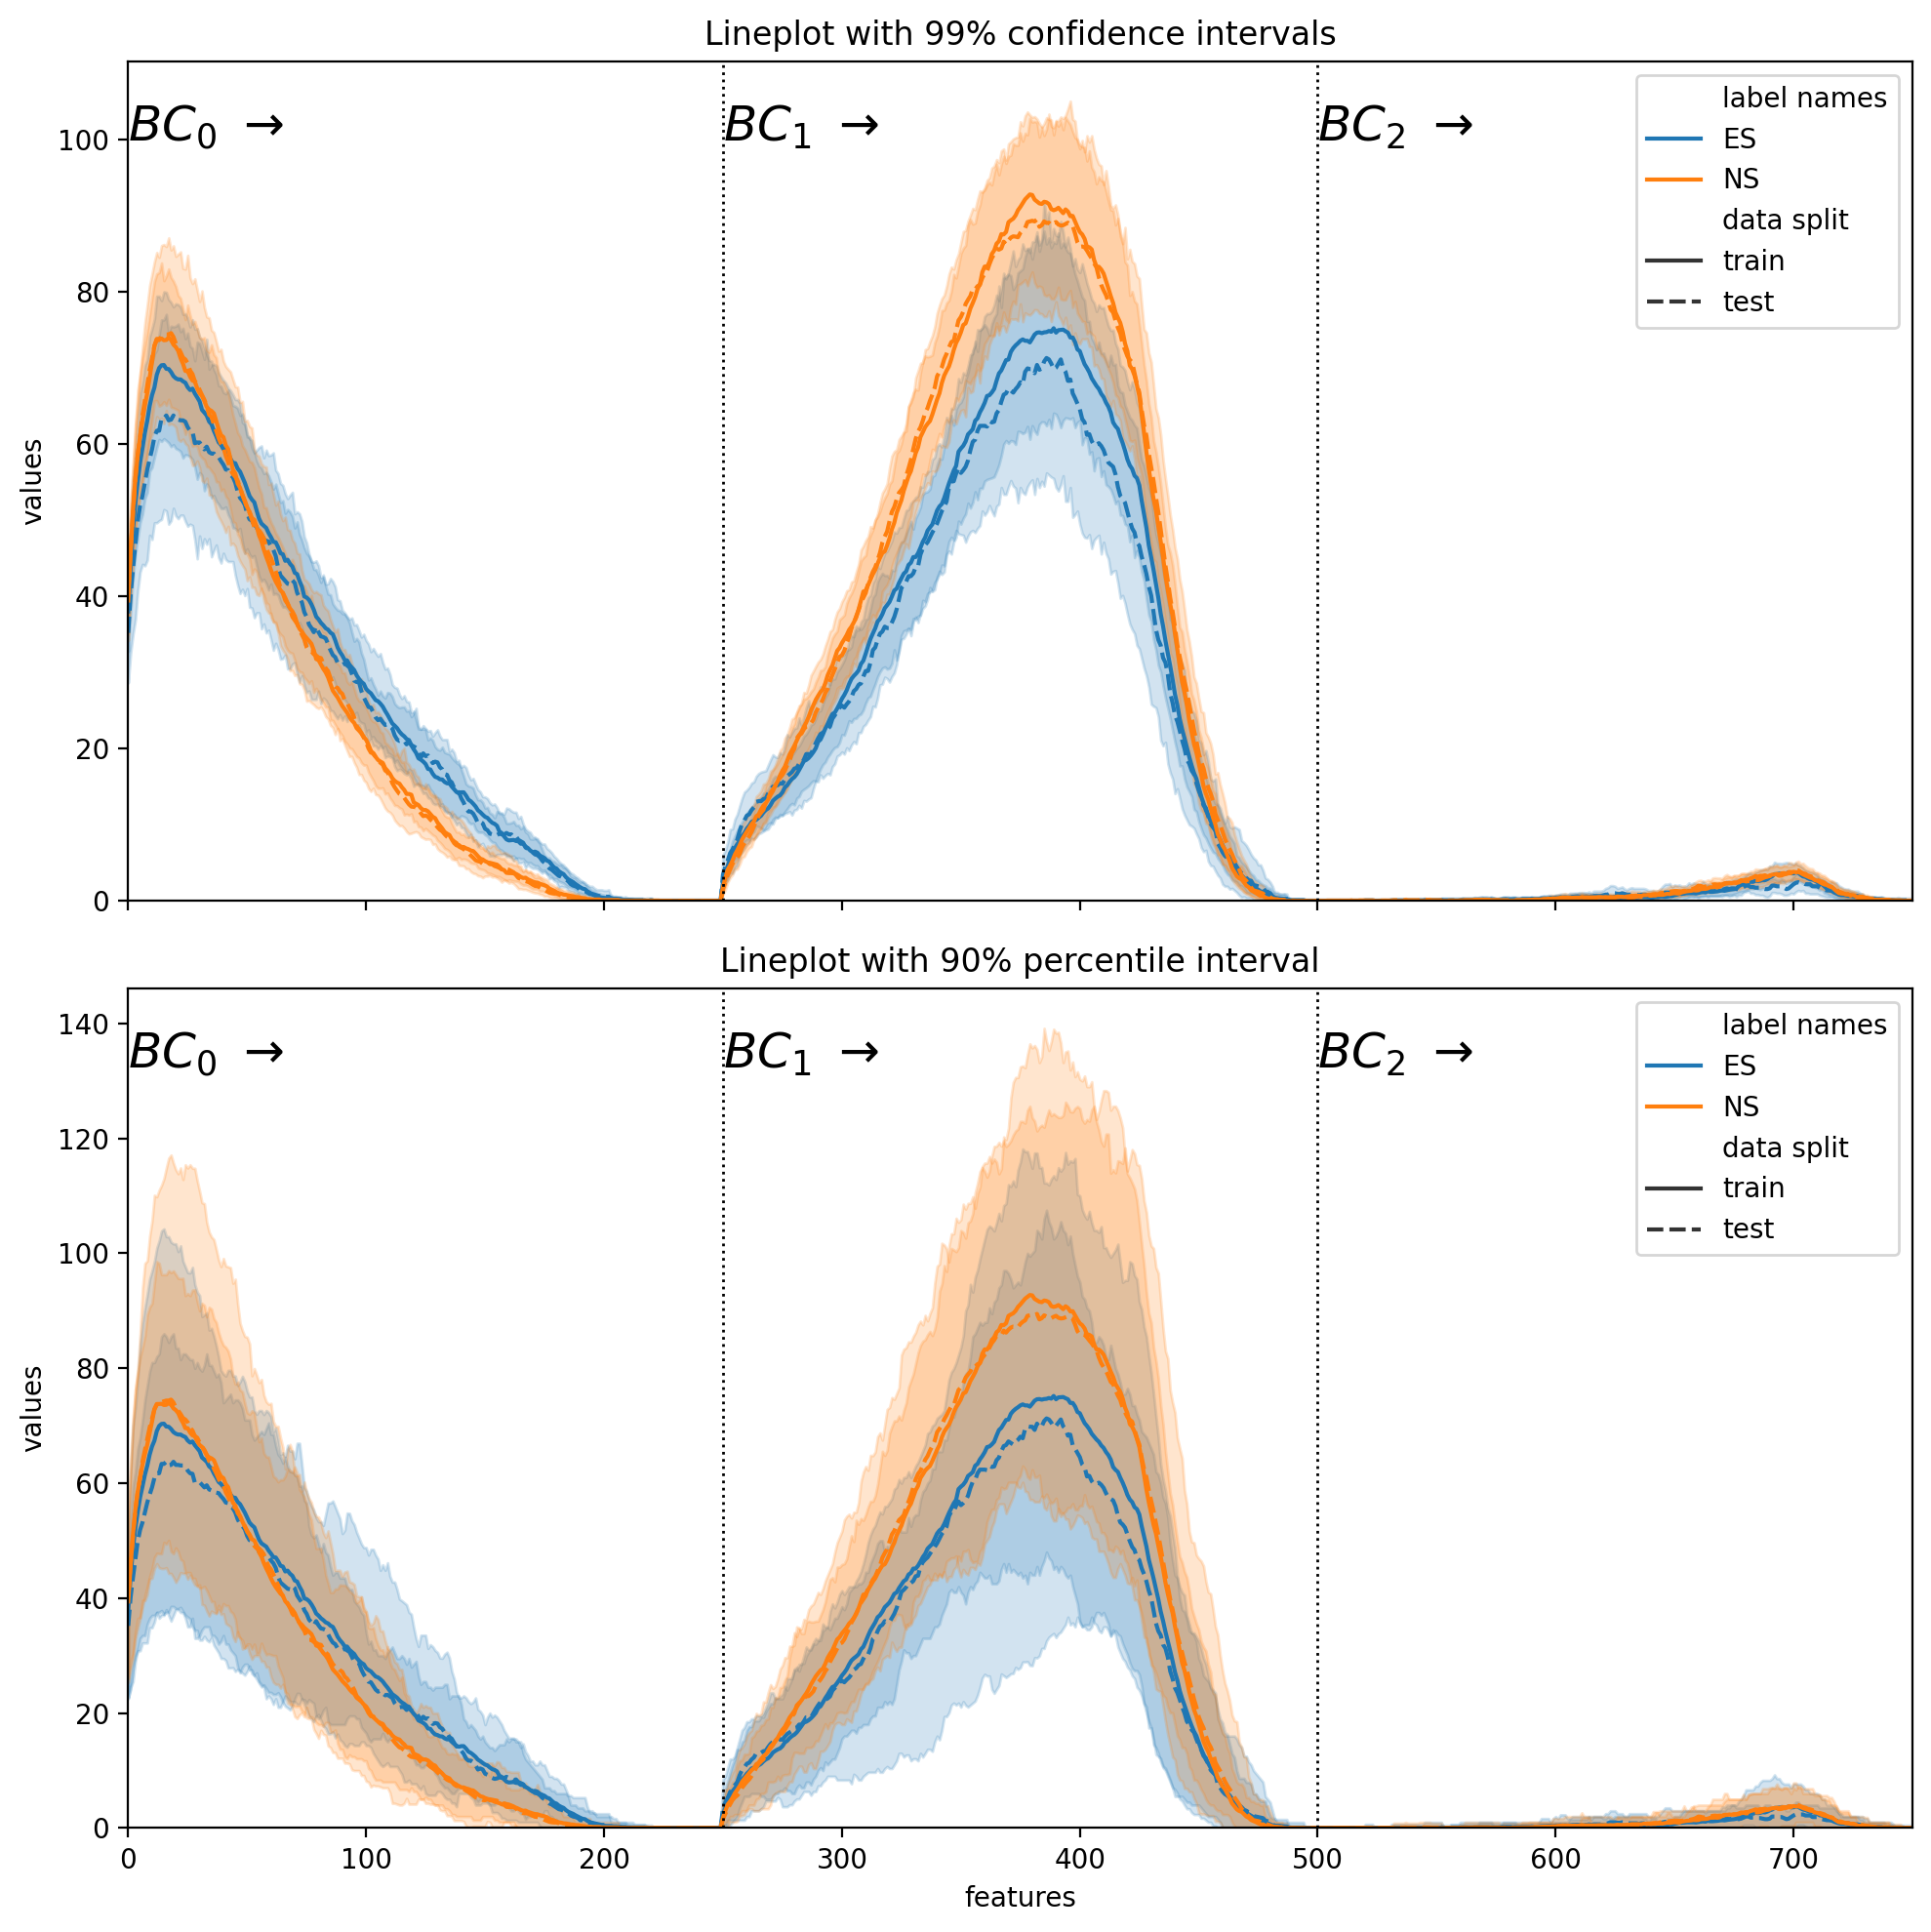

In [33]:
dim = 3
dim = dim -2

df_plot = pd.DataFrame(np.vstack([Xt_train[dim][0], Xt_test[dim][0]]),
                       columns=np.arange(Xt_train[dim][0].shape[1]))
# df_plot['labels'] = np.hstack([y_train, y_test])
# df_plot['train'] = np.hstack([np.ones(len(y_train)), np.zeros(len(y_test))])

# df_melt = df_plot.melt(id_vars=['labels', 'train'], var_name='features', value_name='values')
df_plot.loc[:, 'label names'] = ['ES' if x == 0 else 'NS'
    for x in np.hstack([y_train, y_test]).astype(np.int32)]
df_plot.loc[:, 'data split'] = ['test' if x == 0 else 'train'
    for x in np.hstack([np.ones(len(y_train)), np.zeros(len(y_test))]).astype(np.int32)]

df_melt = df_plot.melt(id_vars=['label names', 'data split'],
                       var_name='features', value_name='values')

fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=200, sharex=True)
sns.lineplot(data=df_melt, x='features', y='values',
             hue='label names', style='data split',
             errorbar=('ci', 99), ax=ax[0])
sns.lineplot(data=df_melt, x='features', y='values',
             hue='label names', style='data split',
             errorbar=('pi', 90), ax=ax[1])

dim_borders = [np.shape(Xt_train[dim][0])[1]/(dim+2) * j 
               for j in range(dim+2 + 1)]
dim_textplacement = [0.1 * (dim_borders[i+1] - dim_borders[i+1]) + dim_borders[i]
                     for i in range(len(dim_borders)-1)]

for i in range(len(ax)):
    ax[i].set_xlim(0, np.shape(Xt_train[dim][0])[1])
    ax[i].set_ylim(0, ax[i].get_ylim()[1])
    for j in range(dim + 2):
        ax[i].text(dim_textplacement[j], 0.95 * ax[i].get_ylim()[1],
                 fr'$BC_{j} ~\rightarrow$', fontsize=18,
                 ha='left', va='top', color='black')
        if j > 0:
            ax[i].vlines(np.shape(Xt_train[dim][0])[1]//(dim+2) * j,
                        ax[i].get_ylim()[0], ax[i].get_ylim()[1],
                        color='black', ls='dotted', lw=1)

ax[0].set_title('Lineplot with 99% confidence intervals')
ax[1].set_title('Lineplot with 90% percentile interval')
fig.tight_layout()


# clustering

In [5]:
preprocessing = 'clip_minmax_gaussian2c_minmax'
df_labels = pd.read_csv(data_pers / 'labels_persistence_sted.csv')
labels = df_labels['labels'].values

pers_all = read_persistence_files(pers_sted, preprocessing)

In [23]:
from gudhi.representations import BettiCurve
from src.auxfunctions import sanitize_persistence

betti = []
for i in range(3):
    data = sanitize_persistence(pers_all[3][i],
            min_pers = 0.05,
            max_birth = -0.2)
    betti.append(BettiCurve(resolution=250).fit_transform(data))

betti = np.hstack(betti)
betti = betti[:, np.std(betti, axis=0) > 0]

betti_scaled = StandardScaler().fit_transform(betti)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import svm

Variance explained: 0.8676821932093027
SVM acuracy: 0.8075313807531381


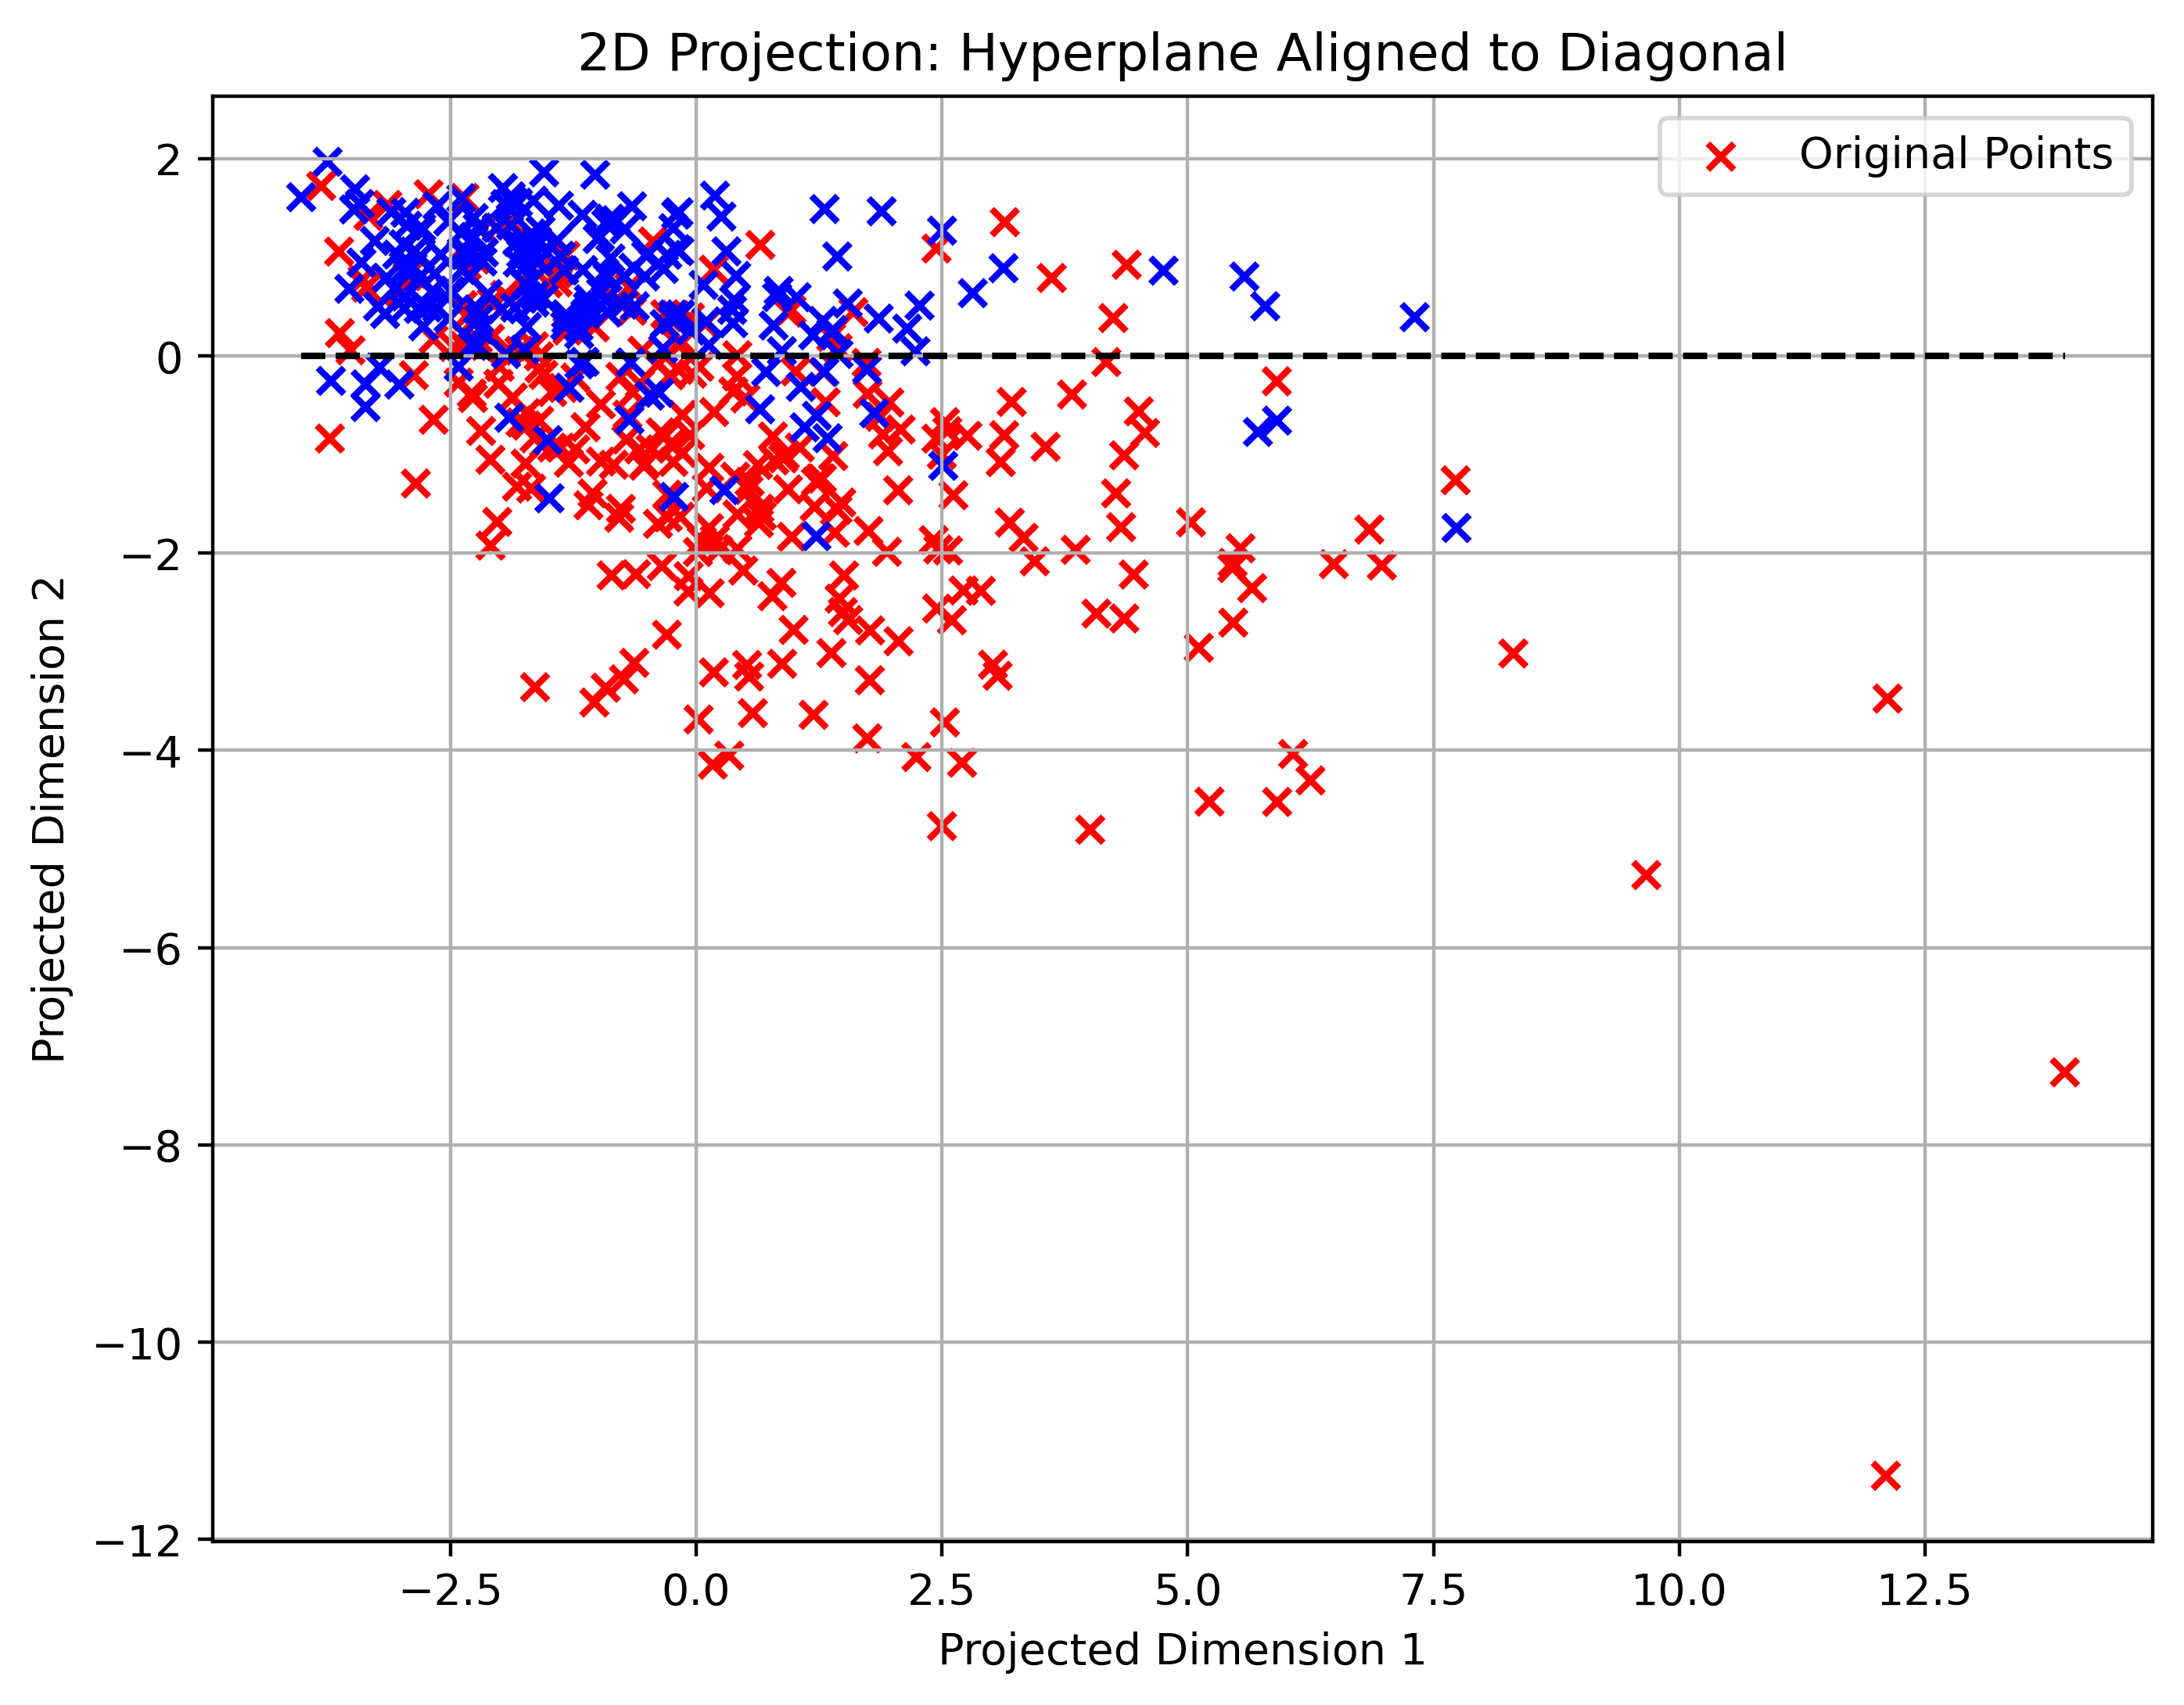

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import svm

Xt = MinMaxScaler().fit_transform(betti)
y = labels.copy()

# Assume X and y are already defined
pca = PCA(n_components=3)
X = pca.fit_transform(Xt)

varexplained = np.sum(pca.explained_variance_ratio_)
print('Variance explained:', varexplained)

# Train SVM with a linear kernel
model = svm.SVC(kernel='linear')
clf = model.fit(X, y)

print('SVM acuracy:', clf.score(X, y))

# Extract hyperplane parameters
w = clf.coef_[0]  # Normal vector to the hyperplane
b = clf.intercept_[0]

# Compute two orthonormal basis vectors that span the hyperplane
w_norm = w / np.linalg.norm(w)  # Normalize w
U, _, _ = np.linalg.svd(np.eye(3) - np.outer(w_norm, w_norm))  # Find orthonormal basis
basis_1, basis_2 = U[:, 1], U[:, 2]  # Two vectors spanning the hyperplane

# Project points onto the hyperplane
distances = (X @ w + b) / np.linalg.norm(w)  # Signed distances
X_hyper = X - np.outer(distances, w_norm)  # Projected points

# Transform hyperplane points into 2D
X_2D = np.column_stack([X_hyper @ basis_1, X_hyper @ basis_2])
Xorg_2D = np.column_stack([X @ basis_1, X @ basis_2])

# Rotate to align with the diagonal (45-degree rotation)
theta = np.pi
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
X_2D_rotated = X_2D @ rotation_matrix
Xorg_2D_rotated = Xorg_2D @ rotation_matrix

y_unq = np.unique(X_2D_rotated[:,1])
assert np.all(np.diff(y_unq) < 1e-14)
y_unq = np.mean(y_unq)


red = (1.0, 0.0, 0.0)
blue = (0.0, 0.0, 1.0)
colors = [red if yx == 0 or yx == 'ES' else blue for yx in y]

# Scatter plot in 2D
plt.figure(figsize=(8, 6), dpi=400)
plt.hlines(0, np.min(Xorg_2D_rotated[:, 0]), np.max(Xorg_2D_rotated[:, 0]), color='black', linestyle='--')
plt.scatter(Xorg_2D_rotated[:, 0], Xorg_2D_rotated[:, 1]-y_unq,
            color=colors, marker='x', label="Original Points")

# Labels
plt.xlabel("Projected Dimension 1")
plt.ylabel("Projected Dimension 2")
plt.title("2D Projection: Hyperplane Aligned to Diagonal")
plt.legend()
plt.grid()